In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
#dropout ewerynode is dropout randomly at each iteration, avoid overfitting,
#robust: does not rely too much on a single node
from keras.optimizers import SGD
#adam ecc are already available
import time
import math

In [16]:
fname="sequences16.csv"
sx, sy = np.loadtxt(fname, delimiter=',',
                   usecols=(0,1), unpack=True, dtype=str)
N=len(sy)
print(N)
Ls=len(sx[0])
print(Ls)

print(sx[0], sy[0])

perc_train=0.7
N_train= int(N*perc_train)
N_test = N-N_train
print(f'\ndata: {N}\ntrain: {N_train}\ntest: {N_test}')

3000
16
AAGGTCTGCCGGCCGA 1

data: 3000
train: 2100
test: 900


In [91]:
Q = ['A', 'C', 'G', 'T']
Nc=4
onehc={Q[i]: i for i in range(Nc)}
print(onehc)

y = sy.astype(int)
L = Ls*Nc
print(L)#length of array feeding NN

x = np.zeros((N, L))
print(x[0])

for n in range(N):
    for i in range(Ls):
        x[n][i*4 + onehc[sx[n][i]]] = 1 #for every step in string you jump of 4 i the autoencpding
        
print(sx[0], x[0])    
print(type(y))


{'A': 0, 'C': 1, 'G': 2, 'T': 3}
64
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
AAGGTCTGCCGGCCGA [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
<class 'numpy.ndarray'>


In [18]:
x_train, y_train = x[:N_train], y[:N_train]
x_test, y_test = x[N_train:], y[N_train:]

score_train = y_train.sum()/len(y_train)
score_test = y_test.sum()/len(y_test)
print(score_train, score_test)


0.24714285714285714 0.24444444444444444


In [32]:
np.random.seed(123)

model = Sequential()
model.add(Dense(L, input_shape=(L,), activation='relu'))
model.add(Dense(L/4, activation='relu'))
#model.add(Dense(L/4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 17        
Total params: 5,217
Trainable params: 5,217
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
42/42 [==============================] - 2s 21ms/step - loss: 0.0593 - accuracy: 0.9880 - val_loss: 0.6350 - val_accuracy: 0.8056
Epoch 2/30
42/42 [==============================] - 0s 10ms/step - loss: 0.0499 - accuracy: 0.9895 - val_loss: 0.6440 - val_accuracy: 0.8056
Epoch 3/30
42/42 [==============================] - 0s 9ms/step - loss: 0.0491 - accuracy: 0.9882 - val_loss: 0.6644 - val_accuracy: 0.8011
Epoch 4/30
42/42 [==============================] - 0s 9ms/step - loss: 0.0384 - accuracy: 0.9953 - val_loss: 0.6814 - val_accuracy: 0.8000
Epoch 5/30
42/42 [==============================] - 0s 10ms/step - loss: 0.0381 - accuracy: 0.9952 - val_loss: 0.6800 - val_accuracy: 0.8033
Epoch 6/30
42/42 [==============================] - 0s 10ms/step - loss: 0.0376 - accuracy: 0.9969 - val_loss: 0.7187 - val_accuracy: 0.8078
Epoch 7/30
42/42 [==============================] - 0s 11ms/step - loss: 0.0345 - accuracy: 0.9945 - val_loss: 0.7337 - val_accuracy: 0.8122
Epoch 8/30
42/4

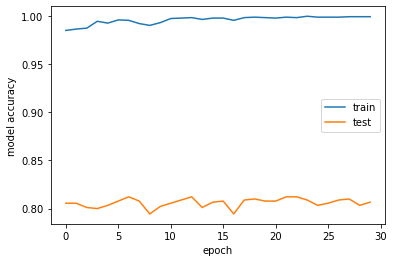

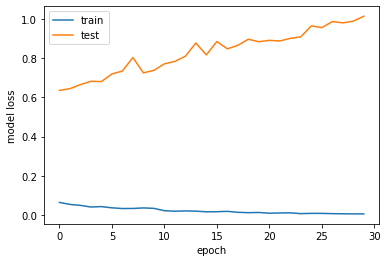

In [39]:
model.compile(loss='binary_crossentropy',
             optimizer='ADAM',
             metrics=['accuracy'])


fit = model.fit(x_train, y_train,
               epochs=30, batch_size=50,
               validation_data=(x_test, y_test),
               shuffle=True #changes composition of mini batch                                
               )


score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [74]:
sx_train = sx[:N_train]
sx_train_augm = []
y_train_augm = []

def shifting(x, positions, label):
    
    shifted_x = []
    shifted_y =  []
    
    shifted_x.append(x)
    shifted_y.append(label)
    
    temp = x
    for j in range(positions):
        temp = temp[-1:]+temp[:-1]
        shifted_x.append(temp)
        shifted_y.append(label)
        
        
    return shifted_x, shifted_y
        
        
position = 15       

for i in range(len(sx_train)):
    sx_train_augm += shifting(sx_train[i], position, y_train[i])[0]
    y_train_augm += shifting(sx_train[i], position, y_train[i])[1]
    
    
      
        
    
    

In [75]:
N_augm = len(sx_train_augm)

In [92]:
Q = ['A', 'C', 'G', 'T']
Nc=4
onehc={Q[i]: i for i in range(Nc)}
print(onehc)

y = sy.astype(int)
L = Ls*Nc
print(L)#length of array feeding NN

x_train_augm = np.zeros((N_augm, L))
print(x_train_augm[0])

for n in range(N_augm):
    for i in range(Ls):
        x_train_augm[n][i*4 + onehc[sx_train_augm[n][i]]] = 1 #for every step in string you jump of 4 i the autoencpding
        
print( type(y_train_augm) )   



{'A': 0, 'C': 1, 'G': 2, 'T': 3}
64
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<class 'list'>


In [80]:
np.random.seed(123)

model = Sequential()
model.add(Dense(L, input_shape=(L,), activation='relu'))
model.add(Dense(L/2, activation='relu'))
model.add(Dense(L/4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None
<class 'numpy.ndarray'>


Epoch 1/30
672/672 [==============================] - 6s 6ms/step - loss: 0.5262 - accuracy: 0.7529 - val_loss: 0.4508 - val_accuracy: 0.7944
Epoch 2/30
672/672 [==============================] - 4s 6ms/step - loss: 0.4467 - accuracy: 0.7921 - val_loss: 0.3746 - val_accuracy: 0.8500
Epoch 3/30
672/672 [==============================] - 4s 6ms/step - loss: 0.3649 - accuracy: 0.8367 - val_loss: 0.3406 - val_accuracy: 0.8489
Epoch 4/30
672/672 [==============================] - 4s 6ms/step - loss: 0.3111 - accuracy: 0.8710 - val_loss: 0.3400 - val_accuracy: 0.8567
Epoch 5/30
672/672 [==============================] - 4s 6ms/step - loss: 0.2840 - accuracy: 0.8845 - val_loss: 0.2996 - val_accuracy: 0.8778
Epoch 6/30
672/672 [==============================] - 4s 6ms/step - loss: 0.2477 - accuracy: 0.9037 - val_loss: 0.2933 - val_accuracy: 0.8811
Epoch 7/30
672/672 [==============================] - 4s 6ms/step - loss: 0.2404 - accuracy: 0.9084 - val_loss: 0.3172 - val_accuracy: 0.8733
Epoch 

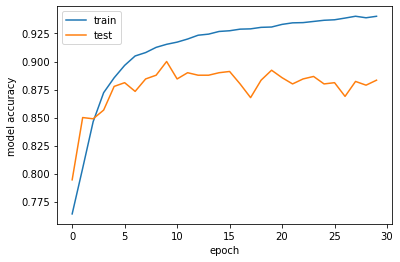

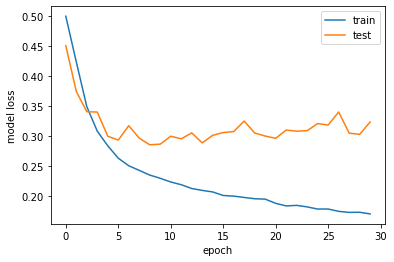

In [95]:
model.compile(loss='binary_crossentropy',
             optimizer='ADAM',
             metrics=['accuracy'])


fit = model.fit(np.asarray(x_train_augm), np.asarray(y_train_augm),
               epochs=30, batch_size=50,
               validation_data=(x_test, y_test),
               shuffle=True #changes composition of mini batch                                
               )


score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()